In [2]:
from math import sqrt
from numpy import concatenate
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import LSTM, Dense, Masking
from tensorflow.keras import callbacks as cb
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
# from hydro_helpers.scoring import render_score
# from hydro_helpers.reporting import cv_report
# from hydro_helpers._utils import _nse as NSE
# from hydro_helpers._utils import _rmse as RMSE
mpl.rcParams['figure.figsize'] = (20, 10)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

In [10]:
pip install hydro_helpers

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement hydro_helpers
ERROR: No matching distribution found for hydro_helpers


In [8]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Collecting tensorflow

  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)
  Using cached grpcio-1.34.1-cp38-cp38-win_amd64.whl (2.9 MB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached termcolor-1.1.0-py3-none-any.whl
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached tensorboard-2.5.0-py3-none-any.whl (6.0 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached absl_py-0.12.0-py3-none-any.whl (129 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached google_auth_oauthlib-0.4.4-py2.py3-

In [28]:
river = 'lena'
df = pd.read_csv('train_df.txt', index_col='date')
print(df.shape)
df.index = pd.DatetimeIndex(df.index)
# print(df.mean(axis=0))
df.head()

(12361, 211)


,stage_max_3019,stage_max_3021,stage_max_3024,stage_max_3027,stage_max_3028,stage_max_3029,stage_max_3030,stage_max_3031,stage_max_3032,stage_max_3035,...,prec_30372,prec_30385,prec_30393,prec_30433,prec_30471,prec_30493,prec_31004,prec_31026,prec_31102,prec_31137
date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,-23.0,103.0,106.0,25.0,258.0,51,126.0,152.0,143.0,59,...,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.2,0.0
1985-01-02,-23.0,103.0,106.0,23.0,258.0,49,122.0,150.0,141.0,58,...,0.0,0.0,0.0,0.9,0.0,0.0,0.5,0.7,0.0,0.7
1985-01-03,-23.0,102.0,106.0,21.0,255.0,47,120.0,147.0,140.0,57,...,0.0,0.0,0.0,0.0,0.0,0.0,0.6,1.6,0.0,0.5
1985-01-04,-24.0,102.0,106.0,19.0,252.0,45,119.0,146.0,139.0,55,...,0.0,0.0,0.6,0.3,0.0,0.2,3.0,0.2,0.3,0.3
1985-01-05,-24.0,102.0,106.0,17.0,251.0,43,119.0,145.0,135.0,53,...,0.0,0.0,0.4,0.0,0.0,0.3,0.6,0.0,0.2,1.8


In [29]:
# run once
df = df.dropna(axis=0, how='all')
df = df.dropna(axis=1, how='all')
# print(df.isna().sum())
print(df.shape)
del df['stage_max_3048']
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
# print(df.isna().sum())
df = df.apply(lambda x: x.fillna(0),axis=0)
print(df.isna().sum())

(12361, 192)
stage_max_3019    0
stage_max_3021    0
stage_max_3024    0
stage_max_3027    0
stage_max_3028    0
                 ..
prec_30493        0
prec_31004        0
prec_31026        0
prec_31102        0
prec_31137        0
Length: 191, dtype: int64


In [30]:
# df.plot(subplots=True, figsize=[20,20])
# plt.show()
corr = round(df.corr(), 2)
# целевые гидропосты
# rownames = [k for k in corr.columns[corr.columns.str.contains("3019|3027|3028|3029|3030|3035|3041|3045|3050|3230|3036")].values]
rownames = [f'stage_max_{i}' for i in [3019,3027,3028,3029,3030,3035,3041,3045,3050,3230,3036]]
# позиция целевых гидропостов
# positions = [i for i, x in enumerate(corr.columns.str.contains("3019|3027|3028|3029|3030|3035|3041|3045|3050|3230|3036]")) if x]
# print(positions)
corr.to_excel('lena_kirensk_corr.xlsx')
corr.loc[rownames, :].transpose().style.background_gradient(cmap='coolwarm')
# corr.style.background_gradient(cmap='coolwarm')

,stage_max_3019,stage_max_3027,stage_max_3028,stage_max_3029,stage_max_3030,stage_max_3035,stage_max_3041,stage_max_3045,stage_max_3050,stage_max_3230,stage_max_3036
stage_max_3019,1.000000,0.780000,0.780000,0.780000,0.780000,0.740000,0.650000,0.640000,0.560000,0.570000,0.710000
stage_max_3021,0.960000,0.780000,0.790000,0.790000,0.790000,0.750000,0.670000,0.670000,0.590000,0.610000,0.740000
stage_max_3024,0.930000,0.800000,0.800000,0.800000,0.790000,0.760000,0.670000,0.680000,0.590000,0.600000,0.740000
stage_max_3027,0.780000,1.000000,0.960000,0.960000,0.930000,0.910000,0.820000,0.820000,0.730000,0.760000,0.880000
stage_max_3028,0.780000,0.960000,1.000000,0.980000,0.940000,0.920000,0.830000,0.830000,0.750000,0.770000,0.900000
stage_max_3029,0.780000,0.960000,0.980000,1.000000,0.950000,0.930000,0.860000,0.860000,0.780000,0.800000,0.920000
stage_max_3030,0.780000,0.930000,0.940000,0.950000,1.000000,0.930000,0.840000,0.830000,0.740000,0.770000,0.920000
stage_max_3031,0.770000,0.910000,0.930000,0.940000,0.960000,0.940000,0.870000,0.860000,0.760000,0.790000,0.930000
stage_max_3032,0.770000,0.920000,0.940000,0.940000,0.950000,0.950000,0.880000,0.870000,0.770000,0.790000,0.930000
stage_max_3035,0.740000,0.910000,0.920000,0.930000,0.930000,1.000000,0.920000,0.890000,0.790000,0.830000,0.970000


In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

def model_build(df, target_label):
    print(target_label)
    test_size = len(df) - int(len(df) * 0.2)
    print('Train: ', test_size)
    print('Test: ', len(df) - test_size)
    dataset = df.values
    data_mean = np.nanmean(dataset[:test_size], axis=0)
    data_std = np.nanstd(dataset[:test_size], axis=0)
    print(dataset[:test_size].shape)
#     print(np.round(data_mean, 3), np.round(data_std, 2))
    dataset = (dataset-data_mean)/data_std
#     print(dataset[:,df.columns.get_loc(target_label)])
    # shaping training and test dataset to chunks
    x_train_multi, y_train_multi = multivariate_data(dataset[:, :], dataset[:, df.columns.get_loc(target_label)], len(dataset) - test_size,
                                                     None, past_history,
                                                     future_target, STEP)
    x_val_multi, y_val_multi = multivariate_data(dataset[:, :], dataset[:, df.columns.get_loc(target_label)],
                                                 0, int(len(df) * 0.2), past_history,
                                                 future_target, STEP)
    print('\n Input training data shape:')
    print(x_train_multi.shape[-2:], y_train_multi.shape[-2:])
    print('\n Input test data shape:')
    print(x_val_multi.shape[-2:], y_val_multi.shape[-2:])
#     print('\n Single step history:')
#     print(x_train_multi[0])
#     print('\n Single step target:')
#     print(y_train_multi[0])

    # create train and test data from chunks
    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

    # training and test data shuffling
    train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
    val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

    multi_step_model = tf.keras.models.Sequential()
    multi_step_model.add(tf.keras.layers.LSTM(50,
                                              return_sequences=False,
                                              input_shape=x_train_multi.shape[-2:]))
    multi_step_model.add(tf.keras.layers.Dense(7))

    multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, 
                                                                beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                                                name='Adam'), 
                             loss='mse')

    model_callbacks = [cb.EarlyStopping(patience=10), 
                              cb.ModelCheckpoint(filepath=f"output/"+ river + "_" + target_label + "_LSTM.h5", save_best_only=True)]
    multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10,
                                          callbacks=model_callbacks)
    loss = multi_step_history.history['loss']
    val_loss = multi_step_history.history['val_loss']
    epochs = range(len(loss)) 
    plt.figure(figsize=[10,10])
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.show()

In [34]:
# define train/test split
target_labels = [f'stage_max_{i}' for i in [3019,3027,3028,3029,3030,3035,3041,3045,3050,3230,3036]]
print(target_labels)
# lookback parameters
past_history = 7 # how many instances a model sees for training, in compliance with other models' input
future_target = 7 # how many instances form a prediction step
STEP = 1 # step size - 1 for daily data
BATCH_SIZE = 30 
BUFFER_SIZE = 1000
EVALUATION_INTERVAL = len(df)/BATCH_SIZE # what data model sees for training
EPOCHS = 100 # how many times a model sees the data

['stage_max_3019', 'stage_max_3027', 'stage_max_3028', 'stage_max_3029', 'stage_max_3030', 'stage_max_3035', 'stage_max_3041', 'stage_max_3045', 'stage_max_3050', 'stage_max_3230', 'stage_max_3036']


stage_max_3019
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 15s 17ms/step - loss: 0.2162 - val_loss: 0.1604
Epoch 2/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0935 - val_loss: 0.1464
Epoch 3/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0633 - val_loss: 0.1599
Epoch 4/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0497 - val_loss: 0.1606
Epoch 5/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0397 - val_loss: 0.1420
Epoch 6/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0372 - val_loss: 0.1528
Epoch 7/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0296 - val_loss: 0.2013
Epoch 8/100
412/412 [==============================] - 5s 13ms/step - loss: 0.0331 - val_loss: 0.1444
Epoch 9/100
412/412 [==================

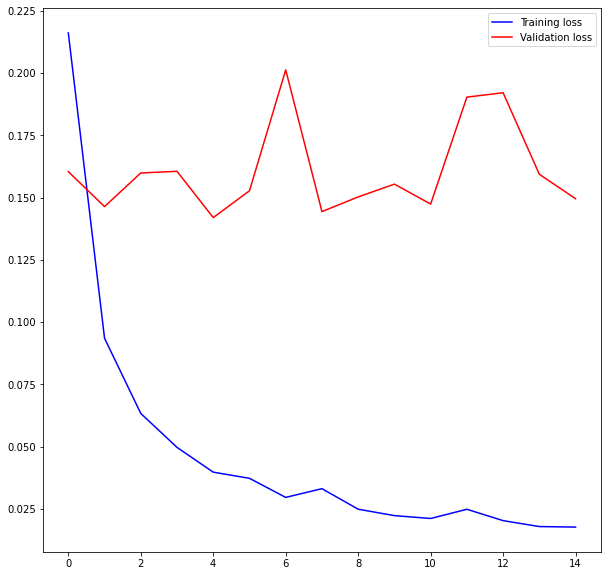

stage_max_3027
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 13s 16ms/step - loss: 0.1970 - val_loss: 0.1745
Epoch 2/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0925 - val_loss: 0.1558
Epoch 3/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0671 - val_loss: 0.1419
Epoch 4/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0577 - val_loss: 0.1453
Epoch 5/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0433 - val_loss: 0.1332
Epoch 6/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0363 - val_loss: 0.1340
Epoch 7/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0354 - val_loss: 0.1277
Epoch 8/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0374 - val_loss: 0.1520
Epoch 9/100
412/412 [==================

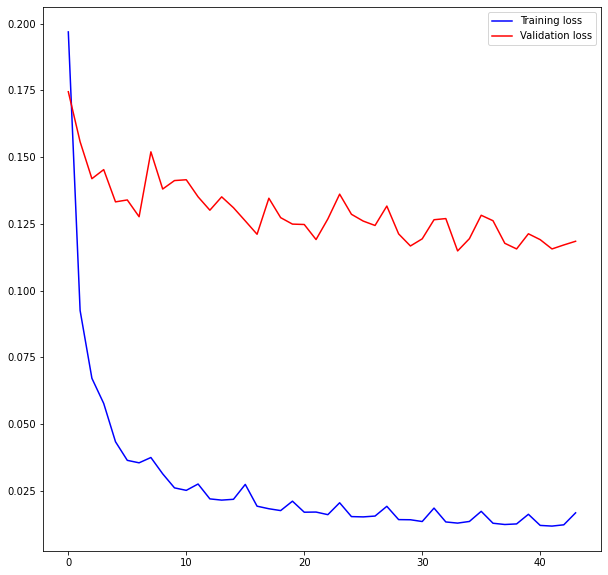

stage_max_3028
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 11s 14ms/step - loss: 0.1717 - val_loss: 0.1169
Epoch 2/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0863 - val_loss: 0.1089
Epoch 3/100
412/412 [==============================] - 4s 10ms/step - loss: 0.0587 - val_loss: 0.0932
Epoch 4/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0496 - val_loss: 0.0681
Epoch 5/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0383 - val_loss: 0.0879
Epoch 6/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0324 - val_loss: 0.1027
Epoch 7/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0279 - val_loss: 0.0933
Epoch 8/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0304 - val_loss: 0.0964
Epoch 9/100
412/412 [==================

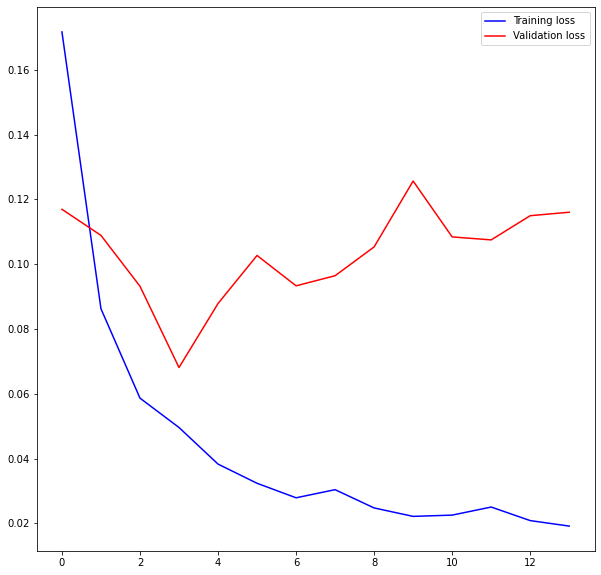

stage_max_3029
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 14s 18ms/step - loss: 0.1492 - val_loss: 0.1080
Epoch 2/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0658 - val_loss: 0.1365
Epoch 3/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0478 - val_loss: 0.0989
Epoch 4/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0446 - val_loss: 0.0925
Epoch 5/100
412/412 [==============================] - 4s 10ms/step - loss: 0.0342 - val_loss: 0.0964
Epoch 6/100
412/412 [==============================] - 4s 10ms/step - loss: 0.0296 - val_loss: 0.1009
Epoch 7/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0248 - val_loss: 0.0886
Epoch 8/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0273 - val_loss: 0.1035
Epoch 9/100
412/412 [==================

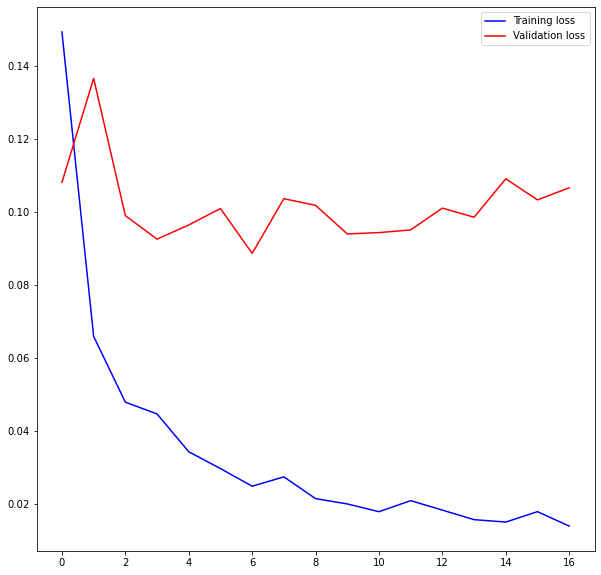

stage_max_3030
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 11s 15ms/step - loss: 0.1740 - val_loss: 0.1504
Epoch 2/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0798 - val_loss: 0.0825
Epoch 3/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0563 - val_loss: 0.0838
Epoch 4/100
412/412 [==============================] - 4s 10ms/step - loss: 0.0508 - val_loss: 0.1022
Epoch 5/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0381 - val_loss: 0.1057
Epoch 6/100
412/412 [==============================] - 4s 10ms/step - loss: 0.0348 - val_loss: 0.0947
Epoch 7/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0305 - val_loss: 0.0778
Epoch 8/100
412/412 [==============================] - 4s 10ms/step - loss: 0.0322 - val_loss: 0.0849
Epoch 9/100
412/412 [==================

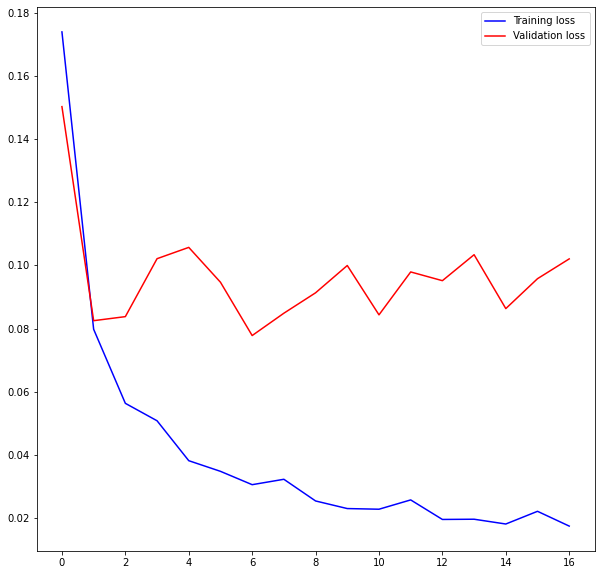

stage_max_3035
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 12s 17ms/step - loss: 0.1403 - val_loss: 0.0694
Epoch 2/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0595 - val_loss: 0.1039
Epoch 3/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0394 - val_loss: 0.0779
Epoch 4/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0328 - val_loss: 0.0713
Epoch 5/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0242 - val_loss: 0.0718
Epoch 6/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0202 - val_loss: 0.0831
Epoch 7/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0196 - val_loss: 0.0764
Epoch 8/100
412/412 [==============================] - 5s 13ms/step - loss: 0.0217 - val_loss: 0.0648
Epoch 9/100
412/412 [==================

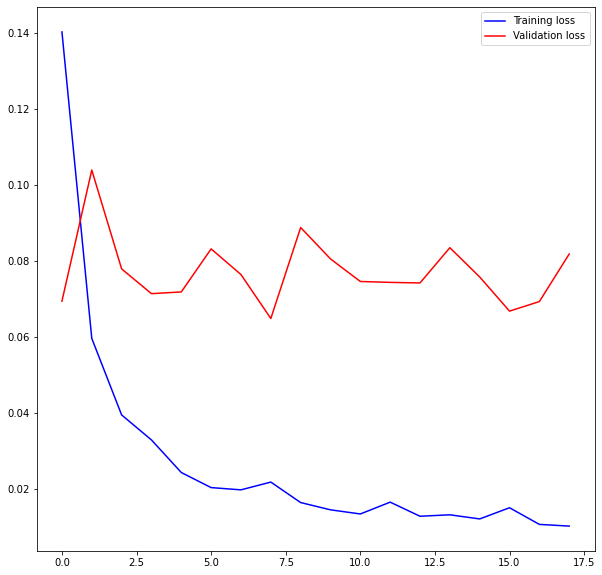

stage_max_3041
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 13s 18ms/step - loss: 0.1146 - val_loss: 0.0838
Epoch 2/100
412/412 [==============================] - 5s 13ms/step - loss: 0.0405 - val_loss: 0.1168
Epoch 3/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0264 - val_loss: 0.1023
Epoch 4/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0271 - val_loss: 0.0951
Epoch 5/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0173 - val_loss: 0.0753
Epoch 6/100
412/412 [==============================] - 6s 14ms/step - loss: 0.0154 - val_loss: 0.0941
Epoch 7/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0142 - val_loss: 0.0852
Epoch 8/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0182 - val_loss: 0.0764
Epoch 9/100
412/412 [==================

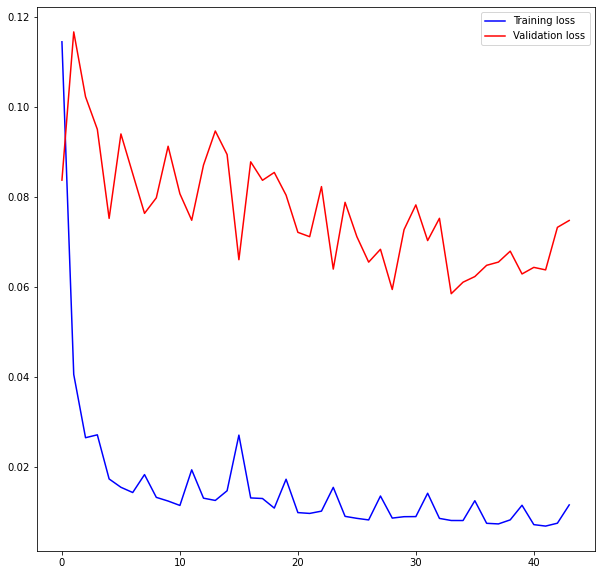

stage_max_3045
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 14s 19ms/step - loss: 0.0989 - val_loss: 0.0467
Epoch 2/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0413 - val_loss: 0.0718
Epoch 3/100
412/412 [==============================] - 5s 13ms/step - loss: 0.0296 - val_loss: 0.0402
Epoch 4/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0299 - val_loss: 0.0365
Epoch 5/100
412/412 [==============================] - 5s 13ms/step - loss: 0.0170 - val_loss: 0.0409
Epoch 6/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0152 - val_loss: 0.0507
Epoch 7/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0137 - val_loss: 0.0453
Epoch 8/100
412/412 [==============================] - 5s 13ms/step - loss: 0.0191 - val_loss: 0.0489
Epoch 9/100
412/412 [==================

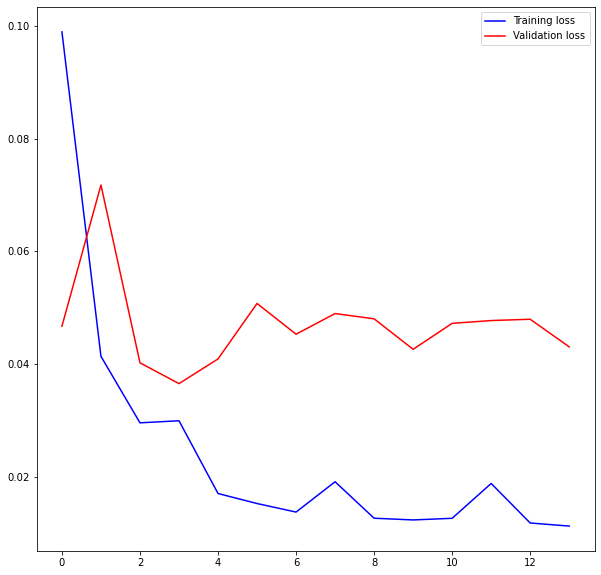

stage_max_3050
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 14s 18ms/step - loss: 0.1551 - val_loss: 0.0980
Epoch 2/100
412/412 [==============================] - 6s 14ms/step - loss: 0.0670 - val_loss: 0.0869
Epoch 3/100
412/412 [==============================] - 6s 14ms/step - loss: 0.0452 - val_loss: 0.0696
Epoch 4/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0526 - val_loss: 0.0657
Epoch 5/100
412/412 [==============================] - 5s 12ms/step - loss: 0.0343 - val_loss: 0.0921
Epoch 6/100
412/412 [==============================] - 5s 11ms/step - loss: 0.0316 - val_loss: 0.0782
Epoch 7/100
412/412 [==============================] - 4s 11ms/step - loss: 0.0294 - val_loss: 0.0684
Epoch 8/100
412/412 [==============================] - 5s 13ms/step - loss: 0.0512 - val_loss: 0.0968
Epoch 9/100
412/412 [==================

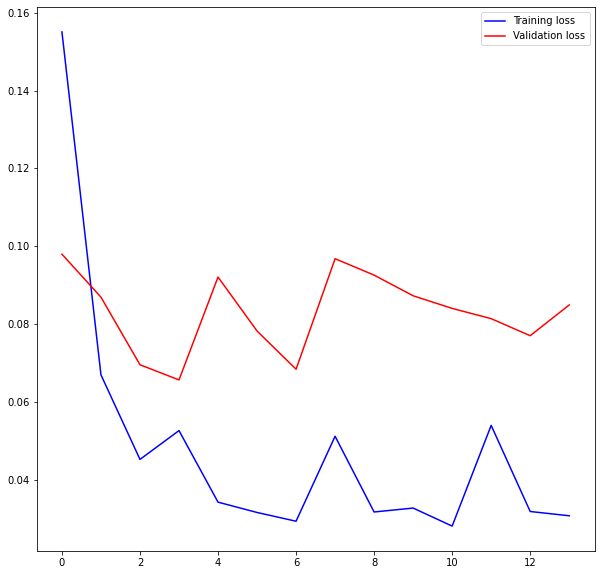

stage_max_3230
Train:  9889
Test:  2472
(9889, 191)

 Input training data shape:
(7, 191) (9875, 7)

 Input test data shape:
(7, 191) (2465, 7)
Epoch 1/100
412/412 [==============================] - 13s 19ms/step - loss: 0.1230 - val_loss: 0.0561
Epoch 2/100
410/412 [============================>.] - ETA: 0s - loss: 0.0475- ETA: 0s - loss: 0

KeyboardInterrupt: 

In [35]:
for l in target_labels:
    model_build(df, l)

In [287]:
# validate prediction
pred = pd.DataFrame(multi_step_model.predict(x_val_multi)) * data_std[df.columns.get_loc(target_label)] + data_mean[df.columns.get_loc(target_label)]

In [37]:
# load trained model for time saving
multi_step_model = load_model(path + "\\output\\"+ river + "_" + target_label + "_LSTM.h5")
# validate prediction
pred = pd.DataFrame(multi_step_model.predict(x_val_multi)) * data_std[df.columns.get_loc(target_label)] + data_mean[df.columns.get_loc(target_label)]
for i in range(future_target):
    pred[i] = pred[i].shift(i)
    pred.columns = [f'pred_{i}' for i in range(1, future_target + 1)]
    start_index = len(df)-test_size
    pred.index = df[past_history:start_index].index.values
    pred['fact'] = df[past_history:start_index][target_label]
    fig, ax = plt.subplots()
    subdf = pred['1990-04-21':'1990-06-15']
    subdf.plot(ax=ax)
    subdf['fact'].plot(ax=ax, lw=5)
    subdf.diff().plot()
    subdf['fact'].diff().plot(lw=5)
    plt.show()
    subdf.head(7)

NameError: name 'x_val_multi' is not defined

In [ ]:
# test model


In [148]:
# расчет метрики

# квадраты стандартных отклонений по гидропостам
STATION_COEFFS = {
        3019: 185.35707752426708,
        3027: 1223.8071616577856,
        3028: 1357.4062812989373,
        3029: 1520.7730161870682,
        3030: 1765.9217904996142,
        3035: 765.3703832632036,
        3041: 443.5766934006718,
        3045: 579.1353554017562,
        3050: 612.0471238561079,
        3230: 516.6669876251401
}

def rowwise_nse(row): 
    station_id = row.station_id
    station_coeff = STATION_COEFFS[station_id]
    
    actual = row['delta_stage_max_actual']
    predicted = row['delta_stage_max_predicted']
    return np.divide(np.square(np.subtract(predicted, actual)),
            station_coeff)

def score(actual_df, predicted_df):
    merged = pd.merge(
        left=predicted_df,
        right=actual_df,
        how='right',
        on=['date', 'station_id'],
        suffixes=('_predicted', '_actual'),
    )

    merged.delta_stage_max_predicted.fillna(0, inplace=True)
    merged['error'] = merged.apply(rowwise_nse, axis=1)
    merged.dropna(inplace=True)
    if len(merged) != len(actual_df):
        return 'length of predicted df does not match actual df'
    else:
        score = np.divide(merged['error'].sum(), len(merged))
        return score

In [20]:
from tensorflow.keras.models import load_model
import os
river = 'lena'
target_label = 'stage_max_3027'
path = os.getcwd()
multi_step_model = load_model(path + "\\output\\"+ river + "_" + target_label + "_LSTM.h5")

In [21]:
multi_step_model

In [24]:
pred = pd.DataFrame(multi_step_model.predict(x_val_multi)) * data_std[df.columns.get_loc(target_label)] + data_mean[df.columns.get_loc(target_label)]
for i in range(future_target):
    pred[i] = pred[i].shift(i)
    pred.columns = [f'pred_{i}' for i in range(1, future_target + 1)]
    start_index = len(df)-test_size
    pred.index = df[past_history:start_index].index.values
    pred['fact'] = df[past_history:start_index][target_label]
    fig, ax = plt.subplots()
    subdf = pred['1990-04-21':'1990-06-15']
    subdf.plot(ax=ax)
    subdf['fact'].plot(ax=ax, lw=5)
    subdf.diff().plot()
    subdf['fact'].diff().plot(lw=5)
    plt.show()
    subdf.head(7)

NameError: name 'x_val_multi' is not defined